# Enron Scandal

In [1]:
#imports
import numpy as np 
import pandas as pd
import os,email,sys,re

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

%matplotlib inline

# Network analysis
import networkx as nx

# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

In [2]:
# Read the data into a DataFrame
emails_df = pd.read_csv('emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
# A single message looks like this
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [4]:
## Helper functions
def get_text_from_email(message):
#To get the content from email objects
    parts = []
    for part in message.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
#To separate multiple email addresses
    if line:
        address = line.split(',')
        address = frozenset(map(lambda x: x.strip(), address))
    else:
        address = None
    return address

In [5]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)

In [6]:
messages[0].keys()

['Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName']

In [7]:
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]

In [8]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf


In [9]:
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

In [10]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.


In [11]:
# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [12]:
emails_df.shape

(517401, 18)

In [13]:
emails_df.describe()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
count,517401,517401,517401,517401,495554,517401,517372,517372,517372,517372,517372,517372,517372,517372,517372,517372,517401,517401
unique,517401,517401,224128,20328,54748,159290,1,2,3,27980,73552,33701,132,5335,259,429,249025,150
top,taylor-m/deleted_items/72.,<32977050.1075840298565.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",(kay.mann@enron.com),(pete.davis@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,,,,\Kay_Mann_June2001_1\Notes Folders\All documents,Kaminski-V,vkamins.nsf,"As you know, Enron Net Works (ENW) and Enron G...",kaminski-v
freq,1,1,1118,16735,9155,19187,517372,479286,494971,16324,9124,388486,517197,6639,26995,24029,112,28465


In [14]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

In [15]:
emails_df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
Message-ID,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [16]:
# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
emails_df.dtypes

Date          datetime64[ns]
From                  object
To                    object
Subject               object
X-From                object
X-To                  object
X-cc                  object
X-bcc                 object
X-Folder              object
X-Origin              object
X-FileName            object
content               object
user                  object
dtype: object

In [17]:
emails_df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
Message-ID,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


# email sent with Year, Day of week, Hour

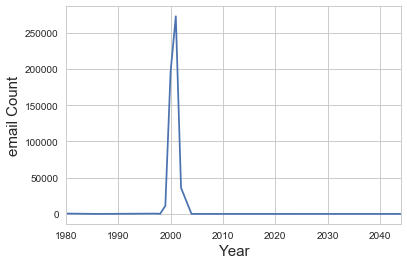

In [20]:
ax = emails_df.groupby(emails_df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('email Count', fontsize=15)

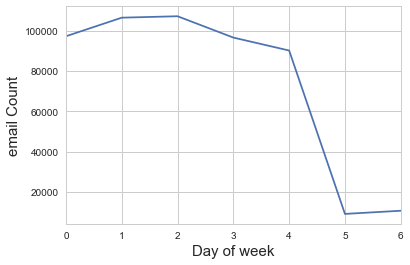

In [22]:
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=15)
ax.set_ylabel('email Count', fontsize=15)

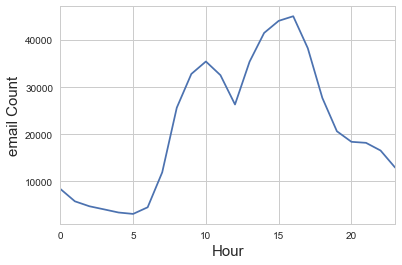

In [23]:
ax = emails_df.groupby(emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('email Count', fontsize=15)

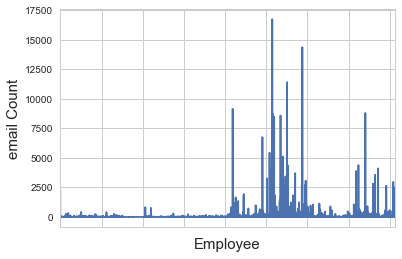

In [26]:
ax = emails_df.groupby(emails_df['From'])['content'].count()
ax=ax.plot()
ax.set_xticklabels([])
ax.set_xlabel('Employee', fontsize=15)
ax.set_ylabel('email Count', fontsize=15)

In [27]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [29]:
emails_df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,subject_wc,content_wc
Message-ID,,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,0,4
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,1,130
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,2,5
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,0,32
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,2,7


In [30]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })

In [32]:
grouped_by_people.head()

,content,subject_wc,content_wc
user,,,
allen-p,3034,3.383652,178.506262
arnold-j,4898,3.261127,266.268885
arora-h,654,4.836391,340.730887
badeer-r,877,6.060433,264.281642
bailey-s,478,4.587866,162.587866


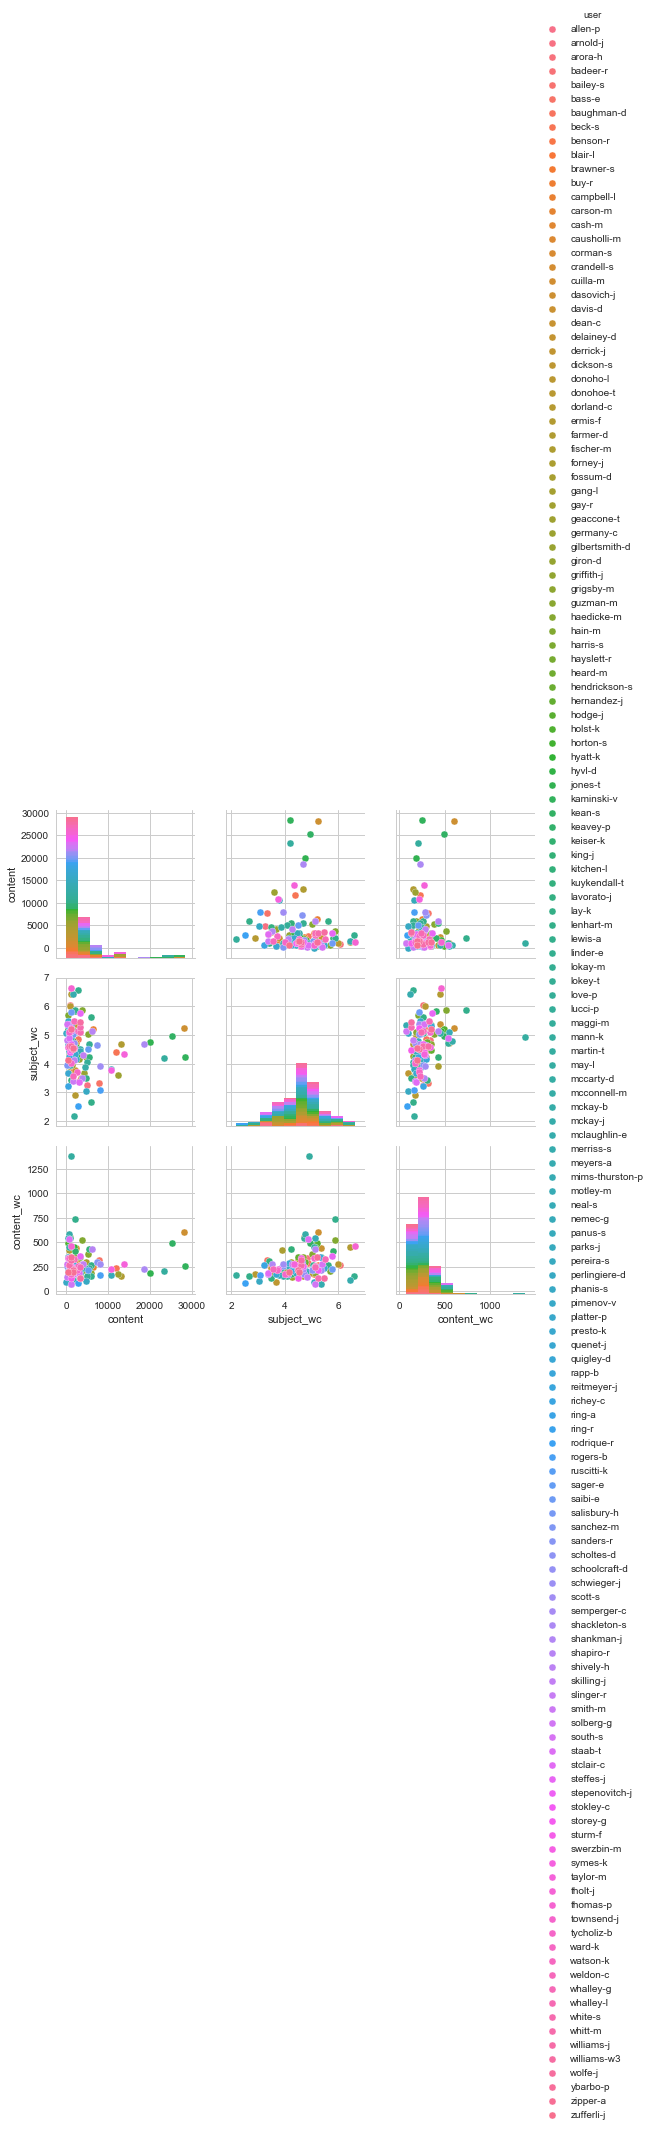

In [33]:
#Pair plot
sns.pairplot(grouped_by_people.reset_index(),hue='user')

# Social network analysis

In [49]:
sub_df = emails_df[['From', 'To', 'Date']].dropna()
sub_df.shape

(495554, 3)

In [50]:
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
sub_df.shape

(354600, 3)

In [51]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
sub_df.head()

,From,To,Date
0,(phillip.allen@enron.com),(tim.belden@enron.com),16
1,(phillip.allen@enron.com),(ben.jacoby@enron.com),3
2,(phillip.allen@enron.com),(vladimir.gorny@enron.com),8
3,(phillip.allen@enron.com),(tbland@enron.com),3
4,(phillip.allen@enron.com),(fescofield@1411west.com),4


In [52]:
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))

In [54]:
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)


In [55]:
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17908,pete.davis@enron.com,pete.davis@enron.com,9141
38033,vince.kaminski@enron.com,vkaminski@aol.com,4308
28920,enron.announcements@enron.com,all.worldwide@enron.com,2206
28935,enron.announcements@enron.com,all.houston@enron.com,1701
26510,kay.mann@enron.com,suzanne.adams@enron.com,1528
38031,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14564,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26309,kay.mann@enron.com,nmann@erac.com,980
18926,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18930,kate.symes@enron.com,kerri.thompson@enron.com,859
